# Prediction of Hip Replacement from OAI Data

The goal of this project is to analyse OAI Data, in order to help predicting hip replacements.
The notebook is organized in 5 sections:
   * **Section 1** - Data Preprocessing
   * **Section 2** - Training for Feature Selection
   * **Section 3** - Training and Testing general model
   * **Section 4** - Time Specific Analysis
   * **Section 5** - Survival Analysis


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

## 1. Data Preprocessing

#### Enrollees data (general information about people in the study)

In [2]:
ENROLLEES = pd.read_csv('Comma Delimited Data/enrollees.csv').drop(['VERSION'],axis=1)
ENROLLEES = ENROLLEES[['ID','P02HISP','P02SEX', 'P02RACE']]

#### Target Data (outcomes99.csv)

In [3]:
dt = pd.read_csv('Comma Delimited Data/outcomes99.csv').drop(['version'],axis=1)

#### Grouping features names by meaning...

In [4]:
tRPCF = [i for i in dt.columns if i[-4:] =='RPCF']   # Knee and hip replacement status during follow-up
tKRPCF = [i for i in dt.columns if i[-5:] =='KRPCF']   # Knee replacement status during follow-up
tHRPCF = [i for i in dt.columns if i[-5:] =='HRPCF']   # Hip replacement status during follow-up
tBLRP = [i for i in dt.columns if i[-4:] =='BLRP']   # Baseline knee or hip replacements
tRPSN = [i for i in dt.columns if i[-4:] =='RPSN']   # Knee or hip replacement seen on follow-up OAI x-ray.
tDAYS = [i for i in dt.columns if i[-4:] =='DAYS']   # Closest OAI contact prior to and after replacement
tVSPR = [i for i in dt.columns if i[-4:] =='VSPR']   # Closest OAI contact prior to replacement
tKVSPR = [i for i in dt.columns if i[-5:] =='KVSPR']   # Closest OAI contact prior to Knee replacement
tHVSPR = [i for i in dt.columns if i[-5:] =='HVSPR']   # Closest OAI contact prior to Hip replacement
tXRPR = [i for i in dt.columns if i[-4:] =='XRPR']   # Closest OAI visit with x-ray prior to replacement
tXRAF = [i for i in dt.columns if i[-4:] =='XRAF']   # Closest OAI visit with x-ray after the replacement

tVSAF = [i for i in dt.columns if i[-4:] =='VSAF']   # Closest OAI contact after the replacement
tDATE = [i for i in dt.columns if i[-4:] =='DATE']   # Date of a replacement
tTLPR = [i for i in dt.columns if i[-4:] =='TLPR']   # Total or Partial replacement indication
tTPPR = [i for i in dt.columns if i[-4:] =='TPPR']   # Type of Partial replacement indication
tPODX = [i for i in dt.columns if i[-4:] =='PODX']   # Primary pre-operative diagnosis
tDEATH = [i for i in dt.columns if i[0:6] =='V99EDD'] # Death columns

DT_outcome = dt[['id'] + tHRPCF + tBLRP + tPODX + tHVSPR + tDEATH + tDAYS]

In [5]:
DT_outcome.head()

,id,V99ERHRPCF,V99ELHRPCF,V99ERKBLRP,V99ELKBLRP,V99ERHBLRP,V99ELHBLRP,V99ERKPODX,V99ELKPODX,V99ERHPODX,...,V99ERHVSPR,V99ELHVSPR,V99EDDCF,V99EDDDATE,V99EDDFLDT,V99EDDVSPR,V99ERKDAYS,V99ELKDAYS,V99ERHDAYS,V99ELHDAYS
0,9000099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9000296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9000622,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,2.0,2006-12-06,1.0,1.0,NaN,NaN,NaN,NaN
3,9000798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9001104,NaN,3.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2091.0


#### Grouping features names by affected joint ...

In [6]:
tELK = [i for i in DT_outcome.columns if i[0:6] =='V99ELK']  # Left Knee Columns
tERK = [i for i in DT_outcome.columns if i[0:6] =='V99ERK']  # Right Knee Columns
tELH = [i for i in DT_outcome.columns if i[0:6] =='V99ELH']  # Left Hip Columns
tERH = [i for i in DT_outcome.columns if i[0:6] =='V99ELH']  # Right Hip Columns
DT_outcome[['id'] + tERH].head(5)

,id,V99ELHRPCF,V99ELHBLRP,V99ELHPODX,V99ELHVSPR,V99ELHDAYS
0,9000099,NaN,NaN,NaN,NaN,NaN
1,9000296,NaN,NaN,NaN,NaN,NaN
2,9000622,NaN,0.0,NaN,NaN,NaN
3,9000798,NaN,NaN,NaN,NaN,NaN
4,9001104,3.0,0.0,4.0,3.0,2091.0


In [7]:
targets = DT_outcome.fillna(0)
targets.describe()

,id,V99ERHRPCF,V99ELHRPCF,V99ERKBLRP,V99ELKBLRP,V99ERHBLRP,V99ELHBLRP,V99ERKPODX,V99ELKPODX,V99ERHPODX,V99ELHPODX,V99ERHVSPR,V99ELHVSPR,V99EDDCF,V99EDDFLDT,V99EDDVSPR,V99ERKDAYS,V99ELKDAYS,V99ERHDAYS,V99ELHDAYS
count,4.796000e+03,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000
mean,9.513826e+06,0.072977,0.067973,0.007923,0.005213,0.006047,0.004379,0.065680,0.071309,0.031902,0.035029,0.139491,0.134696,0.118224,0.056297,0.414721,106.202043,100.611134,43.122811,42.146163
std,2.794781e+05,0.459963,0.442252,0.088669,0.072018,0.077533,0.066033,0.333187,0.408362,0.263180,0.313783,1.006929,0.995190,0.465262,0.230518,1.813524,480.117985,457.614751,305.812206,305.092102
min,9.000099e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.283430e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.522042e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.747572e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.999878e+06,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,7.000000,7.000000,8.000000,8.000000,10.000000,10.000000,2.000000,1.000000,12.000000,3320.000000,3259.000000,3284.000000,3287.000000


### AllClinicalDataset

Reading the data for the joint dataset...

Here, we are trying to consider only the __last visit__, prior to a replacement. We're trying to catch information that refers to a condition before the surgery.

So:
1. Reading datasets from files. Dropping some columns we won't use
2. Renaming columns, changing.. VxxKPNL12, VxxKPNLEVY to... KPNL12, KPNLEVY, etc..   and refering the visit number in a separated column, named 'visit'. (So we can compare variable between the visits)
3. Joining with the information of last visit prior to a replacement.  (this generates a dataset that have one line per visit... per each ID)
4. Keeping just the last visit (-1) prior to replacement, or a specific visit, for each ID.

In [8]:
dt0 = pd.read_csv('Comma Delimited Data/allclinical01.csv').drop(['VERSION'],axis=1)
dt1 = pd.read_csv('Comma Delimited Data/allclinical02.csv').drop(['VERSION'],axis=1) 
dt2 = pd.read_csv('Comma Delimited Data/allclinical03.csv').drop(['VERSION'],axis=1)
dt3 = pd.read_csv('Comma Delimited Data/allclinical04.csv').drop(['VERSION'],axis=1) 
dt4 = pd.read_csv('Comma Delimited Data/allclinical05.csv').drop(['VERSION'],axis=1) 
dt5 = pd.read_csv('Comma Delimited Data/allclinical06.csv').drop(['VERSION'],axis=1) 
dt6 = pd.read_csv('Comma Delimited Data/allclinical07.csv').drop(['VERSION'],axis=1) 
dt7 = pd.read_csv('Comma Delimited Data/allclinical08.csv').drop(['VERSION'],axis=1) 
dt8 = pd.read_csv('Comma Delimited Data/allclinical09.csv').drop(['VERSION'],axis=1) 
dt9 = pd.read_csv('Comma Delimited Data/allclinical10.csv').drop(['VERSION'],axis=1) 
dt10 = pd.read_csv('Comma Delimited Data/allclinical11.csv').drop(['VERSION'],axis=1)

##### Renaming columns (removing Vxx to enable direct comparison between visits)

the visit number information is kept in the 'visit' column

In [9]:
dts = [dt0,dt1,dt2,dt3,dt4,dt5,dt6,dt7,dt8,dt9,dt10]
for j in range(len(dts)):
    d = dts[j]
    col = list(d.columns)
    for i in range(1,len(col)):
        txtcol = col[i]
        col[i] = txtcol[3:]
    d.columns=col
    d['visit'] = j  
ALLDATA = pd.concat(dts,sort=False)

In [10]:
# getting information about the last contact prior to replacement...
visit_to_keep = -1
if visit_to_keep != -1:
    DT_outcome['prior_visit'] = visit_to_keep
else:
    DT_outcome['prior_visit'] = DT_outcome[tHVSPR].max(axis=1).fillna(10) # Last visit prior to replacement...


ALLDATA_VISITS = ALLDATA.merge(DT_outcome[['prior_visit','id']],left_on='ID', right_on='id', how='outer')
ALLDATA_VISITS.head()

,ID,BLDRAW2,ILLPWK2,MULTST2,URINOB1,PLAQHR1,BLUPMN2,HOURSP2,VCOLL2,ILLPWK1,...,ACT37A,ACT37B,ACT37C,ACT37D,ACTNAA,ACTNAB,ACTNAC,ACTNAD,prior_visit,id
0,9000099,NaN,NaN,NaN,1.0,33600.0,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,9000099
1,9000099,NaN,NaN,NaN,1.0,27300.0,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,9000099
2,9000099,NaN,NaN,NaN,1.0,53700.0,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,9000099
3,9000099,NaN,NaN,NaN,1.0,29700.0,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,9000099
4,9000099,NaN,NaN,NaN,1.0,27600.0,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,9000099


In [11]:
all_before = True  # 'True' keeps all visits before visit_to_keep, 'False' keeps only visit_to_keep
if all_before:
    ALLDATA_VISITS = ALLDATA_VISITS[ALLDATA_VISITS['prior_visit'] >= ALLDATA_VISITS['visit']]
else:
    # keeping information of only the last visit
    ALLDATA_VISITS = ALLDATA_VISITS[ALLDATA_VISITS['prior_visit'] == ALLDATA_VISITS['visit']]

In [12]:
ALLDATA_VISITS['lifetime_visits'] = ALLDATA_VISITS['prior_visit'] - ALLDATA_VISITS['visit']
ALLDATA_VISITS['failure_'] = 1
ALLDATA_VISITS['failure_'][ALLDATA_VISITS['prior_visit'] == 10] = 0

In [13]:
print(ALLDATA_VISITS[['visit', 'prior_visit','lifetime_visits','id']].head())
ALLDATA_VISITS = ALLDATA_VISITS.drop(['id'],axis=1)

   visit  prior_visit  lifetime_visits       id
0      0         10.0             10.0  9000099
1      2         10.0              8.0  9000099
2      3         10.0              7.0  9000099
3      4         10.0              6.0  9000099
4      5         10.0              5.0  9000099


In [14]:
#######
# Considering to drop the columns below

tSREPHR = [i for i in ALLDATA_VISITS.columns if i[0:4] =='SREP']   # Ever have replacement surgery where all or part of joint was replaced, self-report
tPSDATE = [i for i in ALLDATA_VISITS.columns if i =='PSDATE']   # Date MRI Safety Screener completed
tSSDATE = [i for i in ALLDATA_VISITS.columns if i =='SSDATE']   # 
tObjects = list(ALLDATA_VISITS.dtypes[ALLDATA_VISITS.dtypes == 'object'].keys())

to_drop = tSREPHR + tPSDATE + tSSDATE + tObjects + ['HRS12','REASON']


ALLDATA_VISITS = ALLDATA_VISITS.drop(to_drop,axis=1)

______________________________
## 2. Training for Feature Selection

So, here we try to select features using the information of feature importance of a classifier trained using **lightgbm** library. We join the outcome dataset with the All_clinical dataset and, after that, create train and test sets, dropping some feature we won't use.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import lightgbm as lgb

In [16]:
target_name = tHRPCF  # choosing replacement adjucation features

# merging targets with jointsx dataset
DATASET = ALLDATA_VISITS.merge(DT_outcome[target_name + ['id']], left_on='ID', right_on='id', how='outer')

train_target_X = DATASET[target_name].sum(axis=1)   ## summing all the replacements
train_target_X = train_target_X.fillna(0)     # if no information, then 0
train_target_X[train_target_X >= 1] = 1       # if greater than 0... at least one replacement occurred

train_features, test_features, train_target, test_target = train_test_split(DATASET, train_target_X, test_size = 0.3)

IDs = train_features['ID']
FAILURES = train_features['failure_']
LAST_VISITS = train_features['prior_visit']
VISITS = train_features['visit']
LIFETIME = train_features['lifetime_visits']

test_IDs = test_features['ID']
test_FAILURES = test_features['failure_']
test_LAST_VISITS = test_features['prior_visit']
test_VISITS = test_features['visit']
test_LIFETIME = test_features['lifetime_visits']

X = DATASET.drop(['ID','id','prior_visit','failure_', 'visit','lifetime_visits','VISDYS'] + target_name,axis=1)
train_features = train_features.drop(['ID','id','prior_visit','failure_', 'visit','lifetime_visits','VISDYS'] + target_name,axis=1)
test_features = test_features.drop(['ID','id','prior_visit','failure_', 'visit','lifetime_visits','VISDYS'] + target_name,axis=1)

#X = X #.fillna(-1)
#X = pd.get_dummies(X)

print('Targets: ', target_name)
print('Dataset: ', ALLDATA_VISITS.shape)
print('Train dataset:', train_features.shape)
print('Test dataset:', test_features.shape)

Targets:  ['V99ERHRPCF', 'V99ELHRPCF']
Dataset:  (43161, 1398)
Train dataset: (30212, 1392)
Test dataset: (12949, 1392)


#### Measuring feature importances

So, here we train a Gradient Boost model with all the feature of the dataset. After training, the importance of each feature is kept in the feature_importances array.

In [456]:
# Create the model with several hyperparameters
model = lgb.LGBMClassifier(learning_rate=0.01, max_depth=5,objective='binary', boosting_type = 'gbdt', n_estimators = 3000)

# Initialize an empty array to hold feature importances
feature_importances = np.zeros(X.shape[1])

iterations = 1
# Fit the model twice to avoid overfitting
for i in range(iterations):
    
    # Split into training and validation set
    train_dt, valid_dt, train_y, valid_y = train_test_split(X, train_target_X, test_size = 0.25, random_state = i)

    print('======================================================================== ')        
    # Train using early stopping
    model.fit(train_dt, train_y, early_stopping_rounds=100, 
              eval_set = [(valid_dt, valid_y)], eval_metric = 'binary_logloss', verbose = 200)

    print('\n===========================================================\nModel ') 
    valid_pred = model.predict_proba(valid_dt, num_iteration=model.best_iteration_)
    vmetrics = confusion_matrix(valid_y,np.argmax(valid_pred,axis=1))
    
    print ('TN',vmetrics[0,0],', FN',vmetrics[1,0],', FP',vmetrics[0,1],', TP',vmetrics[1,1])
    #fpr, tpr, thresholds = metrics.roc_curve(valid_y, valid_pred[:,1])
    #print('AUC = ', metrics.auc(fpr, tpr))  
    print('AUC = ', roc_auc_score(valid_y,valid_pred[:,1]))    
    print ('Acc:', (vmetrics[0,0] + vmetrics[1,1]) / len(valid_y))
    
    print('==============')
    print('\n0 Frequency: ', (1 - valid_y.sum()/len(valid_y)))
    print('\n1 Frequency: ', valid_y.sum()/len(valid_y))
   
    print('\n==================================\nBASELINE') 
    valid_pred = np.zeros(len(valid_y))
    baseline = confusion_matrix(valid_y,valid_pred)
    fpr, tpr, thresholds = metrics.roc_curve(valid_y, valid_pred)
    print ('TN',baseline[0,0],', FN',baseline[1,0],', FP',baseline[0,1],', TP',baseline[1,1])
    print('AUC = ', metrics.auc(fpr, tpr))
    print ('Acc:', (baseline[0,0] + baseline[1,1]) / len(valid_y))
    
    # Record the feature importances
    feature_importances += model.feature_importances_

feature_importances /= iterations

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.101062
[400]	valid_0's binary_logloss: 0.0976107
[600]	valid_0's binary_logloss: 0.0962417
[800]	valid_0's binary_logloss: 0.0953242
[1000]	valid_0's binary_logloss: 0.0948741
[1200]	valid_0's binary_logloss: 0.0945644
[1400]	valid_0's binary_logloss: 0.0944705
[1600]	valid_0's binary_logloss: 0.0944171
Early stopping, best iteration is:
[1567]	valid_0's binary_logloss: 0.0943815

Model 
TN 10509 , FN 274 , FP 2 , TP 6
AUC =  0.854656176523
Acc: 0.974423130386

0 Frequency:  0.974052451117

1 Frequency:  0.0259475488833

BASELINE
TN 10511 , FN 280 , FP 0 , TP 0
AUC =  0.5
Acc: 0.974052451117


Here, the area under ROC curve (AUC) of the trained classifier is **AUC = 0.85**. As we can see, the target value (any hip replacement) is very imbalanced. In comparison, the accuracy of the baseline model (i. e., predicting all the inputs as 0 or no replacement) is also 0.97 (because there are 97% of zeros in the target variable), but the AUC is 0.5. This shows that our trained model is way better than the baseline prediction.

In the next cell, we remove from the dataset all features with 0 importance.

In [457]:
feature_importances = pd.DataFrame({'feature': list(train_features.columns), 'importance': feature_importances}
                                  ).sort_values('importance', ascending = False)

# Find the features with zero importance
least_important = list(feature_importances[feature_importances['importance'] <= 0]['feature'])
print('There are %d no important features' % len(least_important))

There are 651 no important features


In [458]:
feature_importances.head(10)

,feature,importance
590,AGE,613.0
260,HSPSS,583.0
533,WEIGHT,450.0
536,BMI,445.0
358,OAH12CV,407.0
356,CESD,359.0
248,HSMSS,311.0
18,URINHR1,307.0
597,DFUCOLL,284.0
423,BPSYS,266.0


In [459]:
train_features = train_features.drop(columns = least_important)
test_features = test_features.drop(columns=least_important)

print('Resulting Training shape: ', train_features.shape)
print('Testing shape: ', test_features.shape)

Resulting Training shape:  (30212, 741)
Testing shape:  (12949, 741)


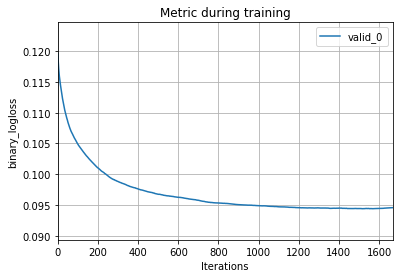

Plot feature importances...


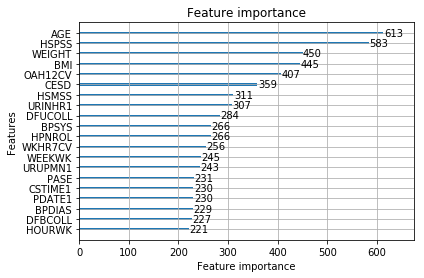

In [460]:
ax = lgb.plot_metric(model, metric='binary_logloss')
plt.show()

print('Plot feature importances...')
ax = lgb.plot_importance(model, max_num_features=20)
plt.show()

The graph above plot the top important features indicated by the gradient boost model, considering the target variable (any hip replacement). These features above are used in later sections.

#### Helper functions

In [20]:
def printConfusionMatrix(test_pred, test_target ,threshold = 0.5):
    pred = np.where(test_pred > threshold, 1., 0.)
    vmetrics = confusion_matrix(test_target, pred)
    print ('TN',vmetrics[0,0],', FN',vmetrics[1,0],', FP',vmetrics[0,1],', TP',vmetrics[1,1])
    print('AUC = ', roc_auc_score(test_target, test_pred))
    print('AUC_classifier = ', roc_auc_score(test_target, pred))
    print ('Acc:', (vmetrics[0,0] + vmetrics[1,1]) / len(test_target))

In [21]:
def printTreeN(model,tree_number=0):

    print('Plot tree ', tree_number)  # one tree use categorical feature to split
    ax = lgb.plot_tree(model, tree_index=tree_number, figsize=(200, 80), show_info=['split_gain'])
    plt.show()

    print('Plot tree with graphviz...')
    graph = lgb.create_tree_digraph(model, tree_index=10, name='Tree')
    graph.render(view=True)

In [22]:
def plotROC(test_target,test_pred):

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    fpr, tpr, thresholds = metrics.roc_curve(test_target, test_pred)
    plt.plot(fpr,tpr, label='(area = {:.3f})'.format(metrics.auc(fpr, tpr)))

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

def plotImportances(model,max_num_features=20):

    print('Plot feature importances...')
    ax = lgb.plot_importance(model, max_num_features=max_num_features)
    plt.show()

In [62]:
def TrainAndTest(train_features, train_target, test_features, test_target, boosting_type='gbdt', max_depth=20, n_estimators = 10000,objective='binary',validation_split=0.25, clf_threshold=0.5, iterations = 10, Testing = False, testing_model=None):

    assert train_features.shape[1] == test_features.shape[1]
    assert train_features.shape[0] == train_target.shape[0]
    assert test_features.shape[0] == test_target.shape[0]
    
    # Fit the model twice to avoid overfitting
    for i in range(iterations):

        if not Testing:
            model = lgb.LGBMClassifier(learning_rate=0.01, max_depth=max_depth, objective=objective, 
                                       boosting_type = boosting_type, n_estimators = n_estimators)
        else:
            model = testing_model

        print('\n=========================================================')
        # splitting test and train dataset...
        print('train: ', train_features.shape, ' test: ' ,test_features.shape)

        # splitting validation and train dataset...
        train_X, valid_X, train_y, valid_y = train_test_split(train_features, train_target, test_size = validation_split)

        if not Testing:
            model.fit(train_X, train_y, early_stopping_rounds=100, eval_set = [(valid_X, valid_y)], eval_metric = 'binary_logloss', verbose = 200)

        print('\n==== Testing best iteration ====')
        test_pred = model.predict_proba(test_features, num_iteration=model.best_iteration_)

        #vmetrics = confusion_matrix(test_target, np.argmax(test_pred,axis=1))
        #print ('TN',vmetrics[0,0],', FN',vmetrics[1,0],', FP',vmetrics[0,1],', TP',vmetrics[1,1])
        if objective=='binary':
            printConfusionMatrix(test_pred[:,1],test_target,threshold=clf_threshold)
            plotROC(test_target,test_pred[:,1])
   
    return model, test_pred

_______________________________________
## 3. Testing general model

Here, we train and test using the features selected from Section 2.


train:  (30212, 741)  test:  (12949, 741)
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.107127
[400]	valid_0's binary_logloss: 0.104546
[600]	valid_0's binary_logloss: 0.104306
Early stopping, best iteration is:
[509]	valid_0's binary_logloss: 0.104023

==== Testing best iteration ====
TN 12640 , FN 306 , FP 0 , TP 3
AUC =  0.809631416165
AUC_classifier =  0.504854368932
Acc: 0.97636883157


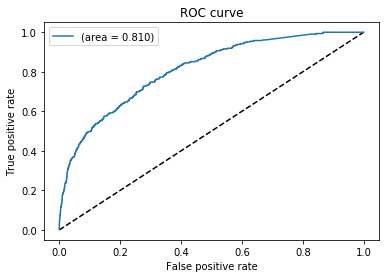

In [470]:
model = TrainAndTest(train_features,train_target,test_features,test_target, iterations=1)

## 4. Time Specific Analysis

In this section, we create classifiers to predict replacements during specific period ahead, from the time of the input data. We create models for 1, 2, 3, and 5 years ahead. We also plot the most important featues for each time horizon.

### Analysis for Time 1 (probability of replacement during next year)

To do this, we create target variables to represent a point in time of the data, related to the point in time of a replacement. We use the feature `lifetime_visits` to create the following variables:
- `target_f` that indicates if a person will have a hip replacement during the next year, from a specific visit. 
- `target_ff` (cumulative) that indicates if a person will have a hip replacement during the next period of analysis (in this case, 1 yr), from a specific visit.
- `target_t` that indicates if a person will survive (will not have a replacement) during certain period of analysis (in this case, 1 yr).
    
First, let's create helper functions to preprocess the input data and define the target for the period of analysis.

In [17]:
def getTimeSpecific(data,time_t_to_predict = 1, drop_columns=True, drop_censored=False, tg_name='target_f', MAX_T = 10):
    dt = data[:]
    dt['target_t'] = 0   # 1 if person should survive more than time_t_to_predict, 0 otherwise...  
    dt['target_f'] = 0   # 1 if person should die at time_t_to_predict, 0 otherwise... 
    dt['target_ff'] = 0  # 1 if person should die until time_t_to_predict, 0 otherwise... 
    dt['target_t'][dt['lifetime_visits'] >= time_t_to_predict] = 1
    dt['target_f'][dt['lifetime_visits'] == time_t_to_predict-1] = 1
    dt['target_ff'][dt['lifetime_visits'] < time_t_to_predict] = 1
    dt['target_f'][dt['prior_visit'] == MAX_T] = 0
    dt['target_ff'][dt['prior_visit'] == MAX_T] = 0
    #dt = dt[dt['lifetime_visits'] == 1]

    if drop_censored:
        dt = dt[dt['visit'] < MAX_T]
        dt = dt[(dt['lifetime_visits'] >= (time_t_to_predict)) | (dt['failure_'] == 1)]
    target = dt[tg_name]
    if drop_columns:
        dt = dt.drop(['ID','id','prior_visit','failure_', 'visit','lifetime_visits','target_f','target_t','target_ff'] + target_name,axis=1)
    
    return dt,target

Training the model considering time horizon of one year (time_t_to_predict = 1), we obtain AUC near 0.85. The AUC_classifier is a metric of the binary classifier, considering a fixed threshold. We don't care too much about this metric right now, because this can be tuned.


train:  (26982, 1392)  test:  (11564, 1392)
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.0276444
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.0272076

==== Testing best iteration ====
TN 11408 , FN 31 , FP 116 , TP 9
AUC =  0.857829312739
AUC_classifier =  0.607467025338
Acc: 0.987288135593


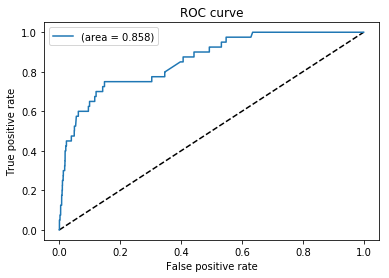


train:  (26982, 1392)  test:  (11564, 1392)
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.0179095
Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.0175129

==== Testing best iteration ====
TN 11345 , FN 28 , FP 179 , TP 12
AUC =  0.876482775078
AUC_classifier =  0.642233599445
Acc: 0.982099619509


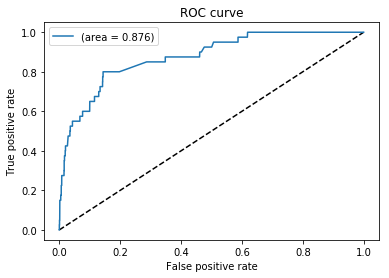


train:  (26982, 1392)  test:  (11564, 1392)
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.0226569

==== Testing best iteration ====
TN 11364 , FN 30 , FP 160 , TP 10
AUC =  0.847926067338
AUC_classifier =  0.618057965984
Acc: 0.983569699066


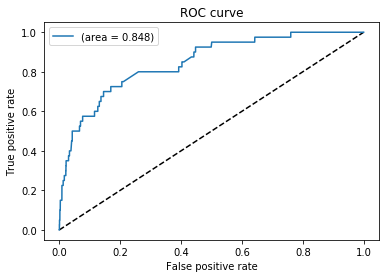

In [70]:
train_t1, target_t1 = getTimeSpecific(DATASET,time_t_to_predict=1,drop_censored=True)
#train_t1 = train_t1.drop(columns=least_important)
train_t1 = train_t1.drop(columns='VISDYS')
train_t1, test_t1, target_t1, test_target_t1 = train_test_split(train_t1,target_t1, test_size=0.3)

model_t1, test_pred_t1 = TrainAndTest(train_t1,target_t1,test_t1,test_target_t1, iterations=3, clf_threshold=0.0134)

Plot feature importances...


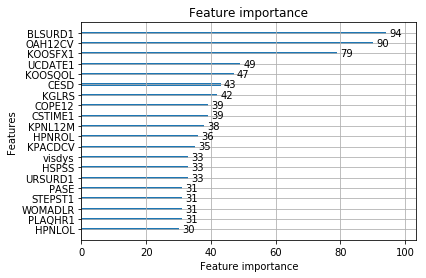

In [71]:
plotImportances(model_t1)

### Analysis for Time 2 (probability of replacement in 2 years)

To do this, we create target variables to represent a point in time of the data, related to the point in time of a replacement. We use the feature `lifetime_visits` to create the following variables:
- `target_f` that indicates if a person will have a hip replacement during the next 2 years, from a specific visit. 
- `target_ff` (cumulative) that indicates if a person will have a hip replacement exactly 2 years from a specific visit. 
- `target_t` that indicates if a person will survive (will not have a replacement) during certain period of analysis (in this case, 2 yrs).


train:  (23751, 1392)  test:  (10180, 1392)
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.0390931
Early stopping, best iteration is:
[223]	valid_0's binary_logloss: 0.0390394

==== Testing best iteration ====
TN 10072 , FN 108 , FP 0 , TP 0
AUC =  0.867788037243
AUC_classifier =  0.5
Acc: 0.989390962672


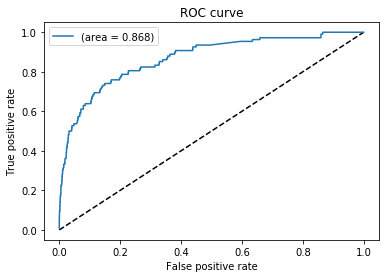


train:  (23751, 1392)  test:  (10180, 1392)
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.0328263
Early stopping, best iteration is:
[262]	valid_0's binary_logloss: 0.0326797

==== Testing best iteration ====
TN 10072 , FN 105 , FP 0 , TP 3
AUC =  0.856485158709
AUC_classifier =  0.513888888889
Acc: 0.989685658153


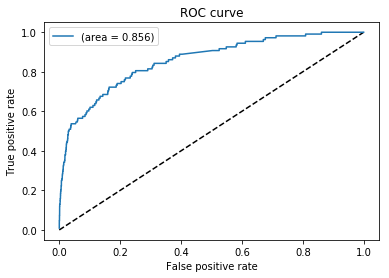


train:  (23751, 1392)  test:  (10180, 1392)
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.0445882
Early stopping, best iteration is:
[204]	valid_0's binary_logloss: 0.0445525

==== Testing best iteration ====
TN 10072 , FN 107 , FP 0 , TP 1
AUC =  0.854791335716
AUC_classifier =  0.50462962963
Acc: 0.989489194499


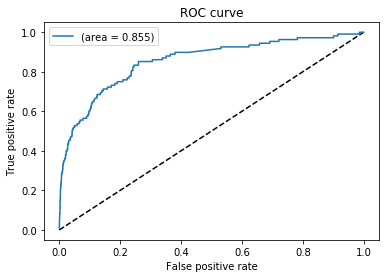

In [73]:
train_t2, target_t2 = getTimeSpecific(DATASET,time_t_to_predict=2,drop_censored=True,tg_name='target_ff')
#train_t2 = train_t2.drop(columns=least_important)
#train_t2 = train_t2.drop(columns='REASON')
train_t2 = train_t2.drop(columns='VISDYS')

train_t2, test_t2, target_t2, test_target_t2 = train_test_split(train_t2,target_t2, test_size=0.3)

model_t2, test_pred_t2 = TrainAndTest(train_t2,target_t2,test_t2,test_target_t2, iterations=3)

Plot feature importances...


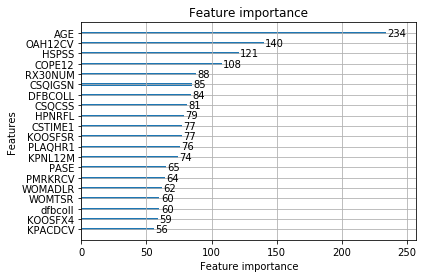

In [74]:
plotImportances(model_t2)

### Analysis for Time 3 (probability of replacement in 3 years)


train:  (20521, 1392)  test:  (8795, 1392)
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.0586386
Early stopping, best iteration is:
[286]	valid_0's binary_logloss: 0.0576028

==== Testing best iteration ====
TN 8673 , FN 105 , FP 1 , TP 16
AUC =  0.852195313438
AUC_classifier =  0.566058058947
Acc: 0.987947697555


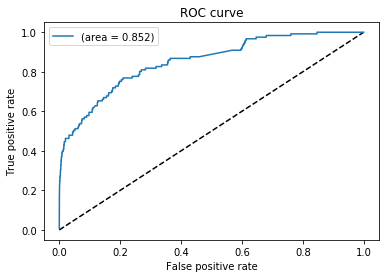


train:  (20521, 1392)  test:  (8795, 1392)
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.0594381
Early stopping, best iteration is:
[237]	valid_0's binary_logloss: 0.0590249

==== Testing best iteration ====
TN 8674 , FN 103 , FP 0 , TP 18
AUC =  0.873292369902
AUC_classifier =  0.574380165289
Acc: 0.988288800455


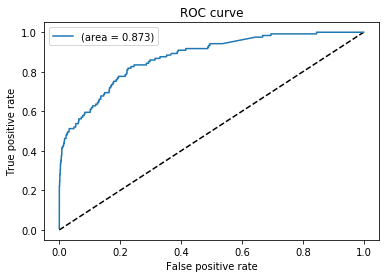


train:  (20521, 1392)  test:  (8795, 1392)
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.060918
Early stopping, best iteration is:
[232]	valid_0's binary_logloss: 0.0606918

==== Testing best iteration ====
TN 8674 , FN 106 , FP 0 , TP 15
AUC =  0.858703792277
AUC_classifier =  0.561983471074
Acc: 0.987947697555


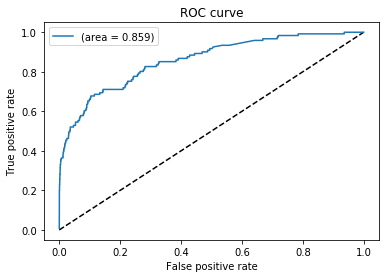

Plot feature importances...


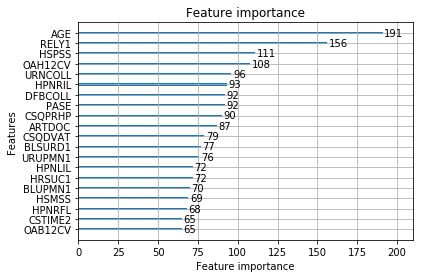

In [75]:
train_t3, target_t3 = getTimeSpecific(DATASET,time_t_to_predict=3,drop_censored=True,tg_name='target_ff')
#train_t3 = train_t3.drop(columns=least_important)
train_t3 = train_t3.drop(columns='VISDYS')

train_t3, test_t3, target_t3, test_target_t3 = train_test_split(train_t3,target_t3, test_size=0.3)

model_t3, test_pred_t3 = TrainAndTest(train_t3,target_t3,test_t3,test_target_t3, iterations=3)

plotImportances(model_t3)

### Analysis for Time 5 (probability of replacement in 5 years)


train:  (14060, 1392)  test:  (6026, 1392)
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.0830461
Early stopping, best iteration is:
[269]	valid_0's binary_logloss: 0.0825282

==== Testing best iteration ====
TN 5831 , FN 109 , FP 1 , TP 85
AUC =  0.868116541513
AUC_classifier =  0.718986431066
Acc: 0.981745768337


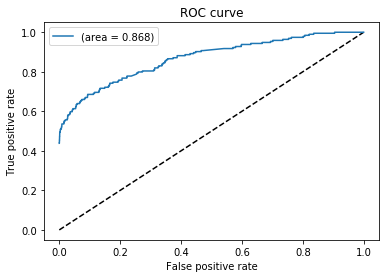


train:  (14060, 1392)  test:  (6026, 1392)
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.0815352
Early stopping, best iteration is:
[260]	valid_0's binary_logloss: 0.0809892

==== Testing best iteration ====
TN 5832 , FN 109 , FP 0 , TP 85
AUC =  0.873831544412
AUC_classifier =  0.719072164948
Acc: 0.981911715898


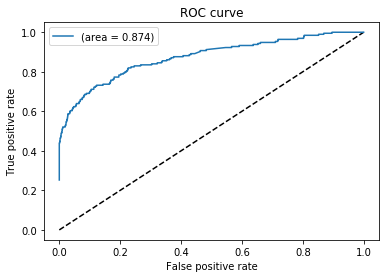


train:  (14060, 1392)  test:  (6026, 1392)
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.0803364
[400]	valid_0's binary_logloss: 0.0787795
Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 0.078026

==== Testing best iteration ====
TN 5832 , FN 109 , FP 0 , TP 85
AUC =  0.857610163619
AUC_classifier =  0.719072164948
Acc: 0.981911715898


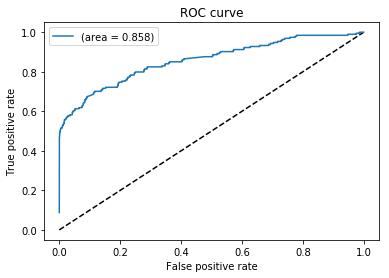

Plot feature importances...


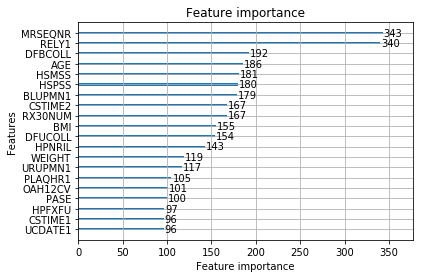

In [76]:
train_t5, target_t5 = getTimeSpecific(DATASET,time_t_to_predict=5,drop_censored=True,tg_name='target_ff')
#train_t5 = train_t5.drop(columns=least_important)
train_t5 = train_t5.drop(columns='VISDYS')

train_t5, test_t5, target_t5, test_target_t5 = train_test_split(train_t5,target_t5, test_size=0.3)

model_t5, test_pred_t5 = TrainAndTest(train_t5,target_t5,test_t5,test_target_t5, iterations=3)
plotImportances(model_t5)

______________________________________________________________________________

## 5. Survival Analysis

Here, we are using **scikit-survival** library to analyse the data, considering `V99ELHDAYS` and `V99ERHDAYS` columns of outcome dataset (days between enrollment visit and follow-up hip replacement) as the `Survival_in_days` target variable. We also use this information to create another variable called `Status` to indicate whether the data is censored or not (i.e. whether the actual survival time was observed or it was censored - this is the case of people who did not have a hip replacement event during the study, dropped out or died before any replacement). These two variables `Survival_in_days` and `Status` are requirements of the scikit-survival model.
The feature `Survival_in_days` must indicate the number of days between a specific follow-up visit and a replacement event, or the end of the study or death of the person. We use the features `VISDYS` from the All_clinical dataset (Days elapsed between baseline (Enrollment Visit) and follow-up visit) to adjust the expectation of survival based on a specific visit. So, the final adjusted `Survival_in_days_adj` is calculated as the `DAYS information - VISDYS information`.

In [548]:
# preparing structured target variables from DT_outcome
dt = DT_outcome.copy()
# if there is information about replacement in days, the data is not censored
dt['Status'] = False
dt['Status'][(dt['V99ERHDAYS'].notna()) | (dt['V99ELHDAYS'].notna())] = True

# for people who died (real death, dropped out) during the study, consider the appropriate survival in days.
# Maximum Survival_in_days is 10 years in days. 
dt['Survival_in_days'] = np.min(dt[['V99ERHDAYS','V99ELHDAYS']].fillna(3650),axis=1)
dt['Survival_in_days'][dt['V99EDDVSPR'] == 0] = 0
dt['Survival_in_days'][dt['V99EDDVSPR'] == 1] = 12 * 30
dt['Survival_in_days'][dt['V99EDDVSPR'] == 2] = 18 * 30
dt['Survival_in_days'][dt['V99EDDVSPR'] == 3] = 24 * 30
dt['Survival_in_days'][dt['V99EDDVSPR'] == 4] = 30 * 30
dt['Survival_in_days'][dt['V99EDDVSPR'] == 5] = 36 * 30
dt['Survival_in_days'][dt['V99EDDVSPR'] == 6] = 48 * 30
dt['Survival_in_days'][dt['V99EDDVSPR'] == 7] = 60 * 30
dt['Survival_in_days'][dt['V99EDDVSPR'] == 8] = 72 * 30
dt['Survival_in_days'][dt['V99EDDVSPR'] == 9] = 84 * 30
dt['Survival_in_days'][dt['V99EDDVSPR'] == 10] = 96 * 30
dt['Survival_in_days'][dt['V99EDDVSPR'] == 11] = 108 * 30
dt['Survival_in_days'][dt['V99EDDVSPR'] == 12] = 120 * 30 
dt['Survival_in_days'][dt['V99ERHDAYS'].notna()] = dt['V99ERHDAYS']
dt['Survival_in_days'][dt['V99ELHDAYS'].notna()] = dt['V99ELHDAYS']

In [549]:
dt[['id', 'Status','Survival_in_days'] + tHRPCF + tDEATH + tDAYS + tHVSPR].head()

,id,Status,Survival_in_days,V99ERHRPCF,V99ELHRPCF,V99EDDCF,V99EDDDATE,V99EDDFLDT,V99EDDVSPR,V99ERKDAYS,V99ELKDAYS,V99ERHDAYS,V99ELHDAYS,V99ERHVSPR,V99ELHVSPR
0,9000099,False,3650.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9000296,False,3650.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9000622,False,360.0,NaN,NaN,2.0,2006-12-06,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,9000798,False,3650.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9001104,True,2091.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2091.0,NaN,3.0


###### Merging with ALLDATA_VISITS

In [550]:
# merging target data with all_clinical dataset and creating an adjusted Survival_in_days 
# to represent the survival time from a specific point during the study
DT = ALLDATA_VISITS.merge(dt, left_on='ID', right_on='id', how='outer')
DT['Survival_in_days_adj'] = DT['Survival_in_days'] - DT['VISDYS'].fillna(0)
DT['Survival_in_days_adj'][DT['Survival_in_days_adj'] < 0] = 0

DT[['id','Survival_in_days','Survival_in_days_adj','visit','VISDYS']].head(5)

,id,Survival_in_days,Survival_in_days_adj,visit,VISDYS
0,9000099,3650.0,3650.0,0,NaN
1,9000099,3650.0,2887.0,2,763.0
2,9000099,3650.0,2723.0,3,927.0
3,9000099,3650.0,2544.0,4,1106.0
4,9000099,3650.0,2169.0,5,1481.0


### Kaplan-Meier Estimation

The graph below shows the probability of survival (not have a replacement event), considering time `t` in days.

Text(0.5,0,'time $t$')

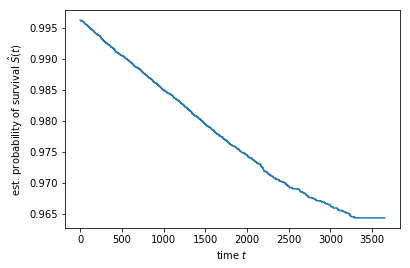

In [551]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(DT["Status"], DT["Survival_in_days_adj"])

plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

Analysing the plot, we can observe that the probability of survival decreases with time. So, the probability of a replacement event increases as time passes, as it is (1 - prob_of_survival). 

### Kaplan-Meier estimation feature by feature, by stratification

To understand the dataset a little more and to see the implications of some features in the survival model, we make a Kaplan_Meier estimation based on stratified data. The function `SurvAnalysisByFeature` divides the data considering some feature (that is discretized in intervals) and make a KM estimation using each stratum of data to measure the effect of the feature in the model.

In [552]:
def SurvAnalysisByFeature(ATTR, Data, n_bins=5):
    ''' This function creates bins to discretize the data of a specific feature ATTR 
    and do the survival analysis on Data, for each bin, plotting the results.
    '''
    Data['BINS'] = pd.cut(Data[ATTR], n_bins)
    for attr in Data['BINS'].unique():
        mask = Data['BINS'] == attr
        if (len(Data[mask & (Data['Status'] == True)]) > 0):
            time_w, survival_prob_w = kaplan_meier_estimator(
                Data['Status'][mask],
                Data['Survival_in_days_adj'][mask])

            plt.step(time_w, survival_prob_w, where="post",
                     label=ATTR + " = %s" % attr)

    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc="best")
    plt.show()

So, let's consider the AGE of the person, because it was one of the important features discovered in the model of **Section 2.**

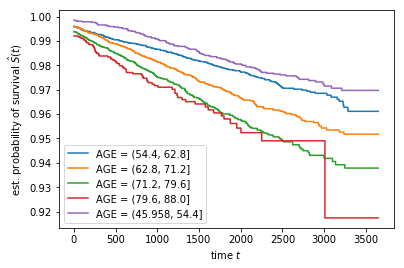

In [553]:
SurvAnalysisByFeature('AGE', DT)

As we can see from the plot, the probability of a hip replacement event increases as older a person is or as longer he or she lives. For a person with age between (54.4, 62.8) years old, for example, the probability of having a hip replacement event in the next 2000 days is almost 2%, as the probability of survival is near 98%. But for a person with age between (79.6, 88.0) the probability of a replacement event increases to near 5%.

When we consider the model by WEIGHT the result is different.

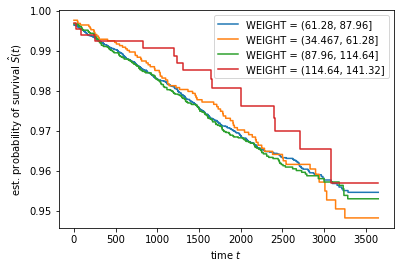

In [519]:
SurvAnalysisByFeature('WEIGHT', DT)

In this case, it is not possible to distinct the groups by WEIGHT, except for the group (114.64, 141.32) which has lower probability of a replacement event.

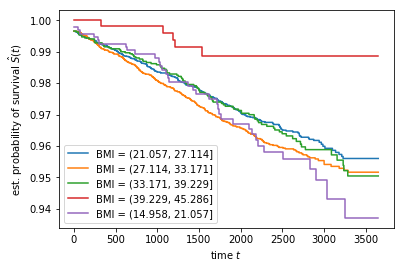

In [480]:
SurvAnalysisByFeature('BMI',DT,7)  # Body Mass index

When considering Body Mass Index, we can see the group between (39.229, 45.286) with lower probability. This group is probably related to the group of WEIGHT (114.64, 141.32).

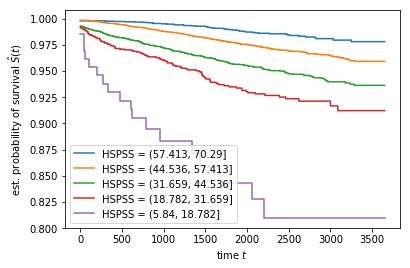

In [481]:
SurvAnalysisByFeature('HSPSS',DT)  #  physical summary scale for the MOS 12-item short-form health survey (SF-12) v2 

Here we can see that the HSPSS has important effects on the survival model.

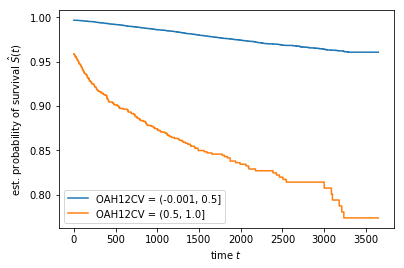

In [482]:
SurvAnalysisByFeature('OAH12CV',DT,2)   # Doctor said you had osteoarthritis/degenerative arthritis in hip, since last visit 

So here: if the doctor said a person has osteoarthritis/degenerative arthritis in hip, the probability of replacement increases a lot. In this case, for example, the probability of a replacement event 1500 days ahead should be near 15%.

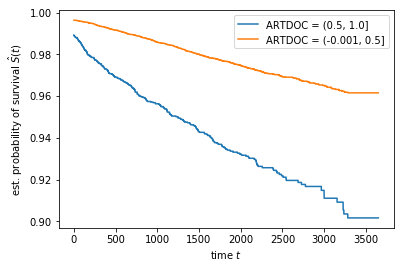

In [614]:
SurvAnalysisByFeature('ARTDOC',DT,2)    # Currently seeing doctor or other health care professional for arthritis 

We can see the same behaviour with ARTDOC feature (Currently seeing doctor or other health care professional for arthritis).

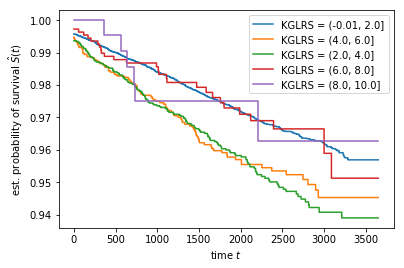

In [618]:
SurvAnalysisByFeature('KGLRS',DT,5) #  Considering all ways knee pain and arthritis affect you, how are you doing today? 

The values of this feature go from 0 to 10 (very good to very poor) considering knee pain. Interesting here is that values in the middle of the scale, 2-6, for example, show lower probability of survival, in contrast with the group 6-8.

### Multivariate Survival Model

If we want to use the model to know the probability of survival (1 - probability of hip replacement), considering the effect of many variables together, we can use a linear model, Cox's proportional hazard's model, to estimate the effect each variable has on the survival model.

In [585]:
# function below returns the features of a specific follow-up visit for a specific person ID
def get_person(_id,dt,visit=0):
    return dt[(dt['ID'] == _id) & (dt['visit'] == visit)]

In [586]:
# get the training data, as the model input
def get_train_x(DT, all_important_features=True, feature_importances=None,n_features=10):

    if all_important_features:
        TRAIN_SV = DT.drop(['prior_visit','lifetime_visits','failure_','BINS','VISDYS'] + list(DT_outcome.keys()),axis=1)
        TRAIN_SV = TRAIN_SV.drop(least_important,axis=1)
    else:
        features = list(feature_importances['feature'][0:n_features]) 
        TRAIN_SV = DT[features]
    return TRAIN_SV

In [587]:
# Creating structured array with Status and Survival_in_days_adj, as required by scikit-survival library
data_y = []
data = DT[['Status','Survival_in_days_adj']]
for i in range(len(data)):
    data_y.append((data.iloc[i]['Status'],data.iloc[i]['Survival_in_days_adj']))
data_y = np.array(data_y,dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

# Getting features for the dataset, passing the feature_importances from the Section 2, to select just a part of the dataset
TRAIN_SV = get_train_x(DT,False,feature_importances, 10)  # 10 most important features (Section 2).

In [588]:
# Splitting the dataset in train and test sets
TRAIN_SV_f, TEST_SV, TRAIN_Y, TEST_Y = train_test_split(TRAIN_SV.fillna(-1),data_y, test_size=0.2)

##### CoxPHSurvivalAnalysis Model

In [589]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

estimator = CoxPHSurvivalAnalysis()
estimator.fit(TRAIN_SV_f,TRAIN_Y)

CoxPHSurvivalAnalysis(alpha=0, n_iter=100, tol=1e-09, verbose=0)

Measuring the performance of the predictor with the test dataset

In [602]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(TEST_SV)
result = concordance_index_censored(TEST_Y["Status"], TEST_Y["Survival_in_days"], prediction)
print('AUC = ', result[0])

AUC =  0.733574833495


So the Area Under ROC Curve (AUC) obtained with the test data in this case was 0.73. The perfect model would get a AUC = 1.

#### Plotting some samples

Let's get the data from a follow-up visit of a person and see the probability of survival in comparison with other sample, considering only 10 most important features from Section 2.

In [607]:
p1 = get_person(9000099,DT,7)   # patient 9000099 on visit 7
p1 = get_train_x(p1,False,feature_importances,10)
p2 = get_person(9013941,DT,2)   # patient 9013941 on visit 2
p2 = get_train_x(p2,False,feature_importances,10)
p = pd.concat([p1,p2])

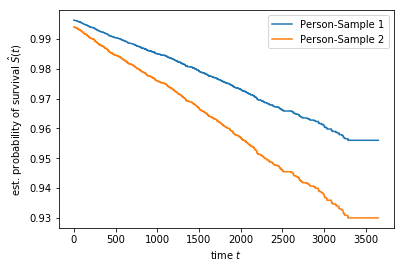

,AGE,HSPSS,WEIGHT,BMI,OAH12CV,CESD,HSMSS,URINHR1,DFUCOLL,BPSYS
6,65.0,46.033064,80.3,24.5,0.0,0.0,61.265442,20700.0,-90.0,100.0
599,69.0,46.033064,87.4,28.2,0.0,7.0,61.265442,31200.0,115.0,140.0


In [609]:
pred_surv = estimator.predict_survival_function(p.fillna(-1))
for i, c in enumerate(pred_surv):
    plt.step(c.x, c.y, where="post", label="Person-Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")
plt.show()
p

In this example, one can see that person 2 has lower probability of survival (greater probability of hip replacements). In the next 3000 days, person 2 is likely to have a hip replacement with more than 6% probability. Person 1, instead, near 4%. 

### Selecting Features Again

Next, we want to investigate which single variable is the best risk predictor. Therefore, we fit a Cox model to each variable individually and record the c-index on the training set.

In [612]:
import numpy as np

def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis(verbose=0)
    for j in range(n_features):
        if j % 10 == 0:
            print ('Feature ' + str(j) + '...')
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

TRAIN_SV = get_train_x(DT,False,feature_importances,60)  # Taking just 60 features

scores = fit_and_score_features(TRAIN_SV.fillna(-1).values, data_y)
pd.Series(scores, index=TRAIN_SV.columns).sort_values(ascending=False)

Feature 0...
Feature 10...
Feature 20...
Feature 30...
Feature 40...
Feature 50...


OAH12CV    0.660546
ARTDOC     0.652720
AGE        0.652028
KGLRS      0.635046
WOMADLR    0.622302
KQOL3      0.621880
DILKN9     0.621785
WOMTSR     0.621572
CESD       0.603523
RX30NUM    0.601973
HPR12CV    0.598947
HPL12CV    0.591081
DIRKN5     0.589458
TIMET1     0.577621
TIMET2     0.575743
P30VT1     0.575284
HPNROL     0.573173
KOOSYML    0.570691
HSMSS      0.568420
PASE6      0.566453
HPNLOL     0.564468
P30VT6     0.563281
BPSYS      0.560988
KOOSKPR    0.557925
HPNRIL     0.554389
KPNR12M    0.553195
BMI        0.550421
WEIGHT     0.550410
BLDHRS1    0.547551
SEAQHR1    0.547438
VITDAMT    0.546461
HOURSP1    0.545856
BPDIAS     0.545478
URINHR1    0.545340
PDATE1     0.544535
HRSUC1     0.543431
PLAQHR1    0.543146
BLSURD1    0.541628
BLUPMN1    0.541165
URUPMN1    0.536963
KOOSQOL    0.535556
DFUCOLL    0.535151
CSTIME1    0.529976
ABCIRC     0.529789
PASE       0.529302
HEIGHT     0.529291
RLVERT     0.523866
KOOSFSR    0.522526
CSTIME2    0.522042
WEEKWK     0.517499


### Next Steps

Following this survival model, these features could be analysed with domain knowledge by domain specialists, so that we can see the true feature importance, helping to create better models and to extract information from it.